# SOSE HEAT BUDGET

(isel not sel)

In [106]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [107]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.23ea85beb98d46f4ac48b1b9d42191d6/status,


In [1]:
client.close()
cluster.close()

NameError: name 'client' is not defined

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec

## Open SOSE Dataset from the Cloud

In [2]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

mapping = fs.get_mapper('gcs://pangeo-ecco-sose')

ds = xr.open_zarr(mapping, consolidated=True)

In [3]:
coordsr = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## New northern boundary | Visualize the ACC region you're going to ignore

In [108]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

t = 30
Z = 0

coords = coordsr.roll(XC=700, XG=700, roll_coords=True).isel(time=t, Z=Z, **lat_range, **lon_range, **lat_range_u, **lon_range_u)
coords_z = coordsr.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = dsr.roll(XC=700, XG=700, roll_coords=True).isel(time=t, Z=Z, **lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds_z = dsr.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

In [5]:
temp = ds.THETA.drop('XC')
mask = coords.drop('XC').hFacC > 0

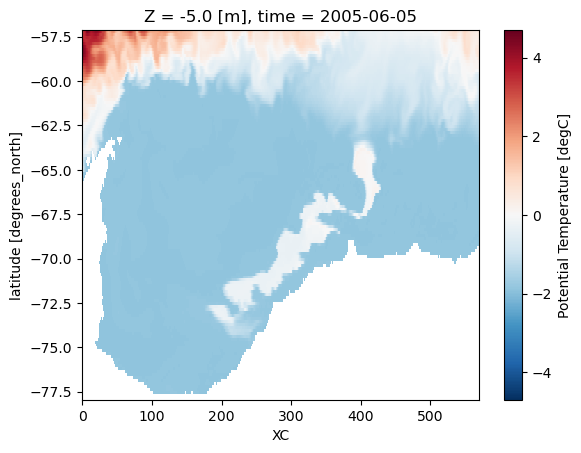

In [6]:
temp.where(mask).plot();

In [7]:
#mask out the acc in the corner
mask_acc = xr.ones_like(temp)

mask_acc[88:None, None:57] = 0
mask_acc[77:88, None:36] = 0
mask_acc[73:77, None:5] = 0

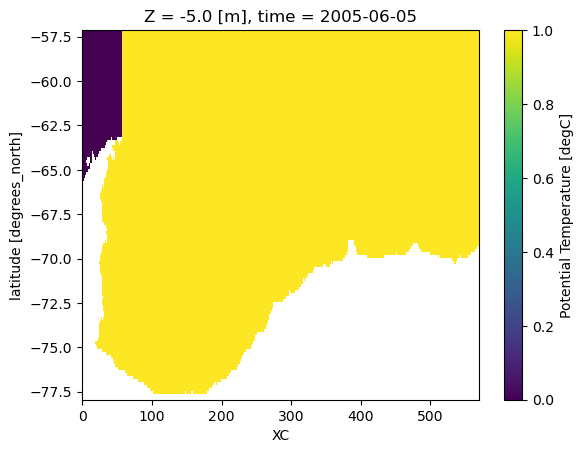

In [8]:
mask_acc.where(mask).plot();

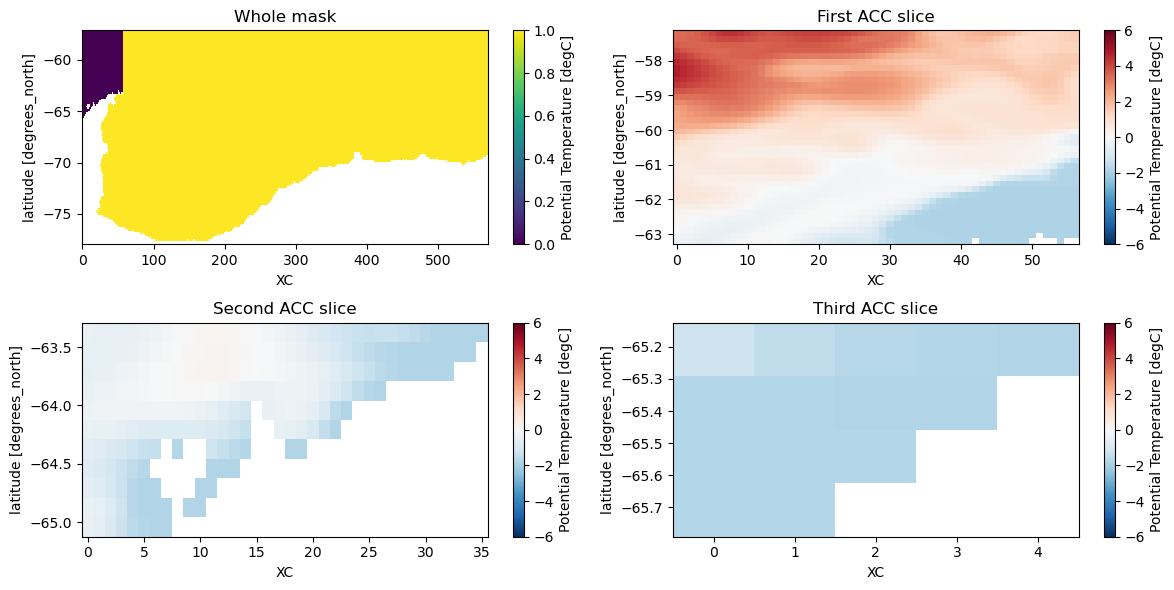

In [9]:
#visualize the 3 masks
fig, ax = plt.subplots(2,2, figsize=(12,6))

mask_acc.where(mask).plot(ax=ax[0,0])
ax[0,0].set_title('Whole mask')
temp.where(mask)[88:None, None:57].plot(ax=ax[0,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[0,1].set_title('First ACC slice')
temp.where(mask)[77:88, None:36].plot(ax=ax[1,0], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,0].set_title('Second ACC slice')
temp.where(mask)[73:77, None:5].plot(ax=ax[1,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,1].set_title('Third ACC slice')

plt.tight_layout();

In [12]:
assert ds.XG[0].values < ds.XC[0].values
assert ds.YG[0].values < ds.YC[0].values

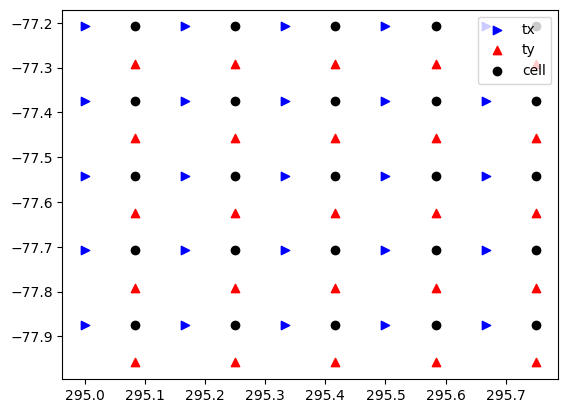

In [114]:
#visualize SOSE's grid
#first 5 grid pts
from matplotlib import pyplot as plt

tx_y, tx_x = xr.broadcast(*(ds[dim] for dim in ds.UVEL.dims))
ty_y, ty_x = xr.broadcast(*(ds[dim] for dim in ds.VVEL.dims))
cell_y, cell_x = xr.broadcast(ds.YC, ds.XC)

plt.scatter(tx_x[:5, :5], tx_y[:5, :5], color='b', label="tx", marker=">")
plt.scatter(ty_x[:5, :5], ty_y[:5, :5], color='r', label="ty", marker="^")
plt.scatter(cell_x[:5, :5], cell_y[:5, :5], color='k', label="cell", marker="o")
plt.legend(loc="upper right");

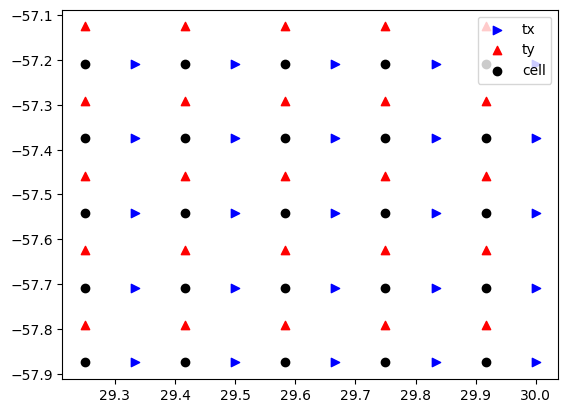

In [113]:
#visualize SOSE's grid
#last 5 grid pts
from matplotlib import pyplot as plt

tx_y, tx_x = xr.broadcast(*(ds[dim] for dim in ds.UVEL.dims))
ty_y, ty_x = xr.broadcast(*(ds[dim] for dim in ds.VVEL.dims))
cell_y, cell_x = xr.broadcast(ds.YC, ds.XC)

plt.scatter(tx_x[-5:, -5:], tx_y[-5:, -5:], color='b', label="tx", marker=">")
plt.scatter(ty_x[-5:, -5:], ty_y[-5:, -5:], color='r', label="ty", marker="^")
plt.scatter(cell_x[-5:, -5:], cell_y[-5:, -5:], color='k', label="cell", marker="o")
plt.legend(loc="upper right");

In [110]:
# Given upper right / lower left cell coordinates, construct the tx_trans and ty_trans sections that bound it

def box_budget(left_i, right_i, lower_j, upper_j,):
    """Function to compute box budget given any set of boundaries"""

    UTRANS = ds_z.UVEL * coords_z.dyG * coords_z.drF * coords_z.hFacW
    VTRANS = ds_z.VVEL * coords_z.dxG * coords_z.drF * coords_z.hFacS

    ty_upper = VTRANS.isel(XC=slice(left_i, right_i), YG=upper_j)
    ty_lower = VTRANS.isel(XC=slice(left_i, right_i), YG=lower_j)
    tx_right = UTRANS.isel(XG=right_i, YC=slice(lower_j, upper_j))
    tx_left = UTRANS.isel(XG=left_i, YC=slice(lower_j, upper_j))

    return (-ty_upper.mean('time').sum().values + ty_lower.mean('time').sum().values 
            - tx_right.mean('time').sum().values + tx_left.mean('time').sum().values)

In [111]:
box1 = box_budget(57, 570, 88, 125)
box2 = box_budget(36, 570, 77, 88)
box3 = box_budget(5, 570, 73, 77)
box4 = box_budget(0, 570, 0, 73)

residual = box1 + box2 + box3 + box4
(residual / 1e6)

-0.0437566015625

## Heat budget for WG (entire water column)

In [117]:
def box_budget(da_i, da_j, left_i, right_i, lower_j, upper_j, bs=None):
    
    """Function to compute box budget given any set of boundaries.
        da_i and da_j are the zonal and meridional dataarrays, respectively.
        bs is the boundary side argument specification."""

    upper = da_j.isel(XC=slice(left_i, right_i), YG=upper_j).rename('upper')
    lower = da_j.isel(XC=slice(left_i, right_i), YG=lower_j).rename('lower')
    right = da_i.isel(XG=right_i, YC=slice(lower_j, upper_j)).rename('right')
    left = da_i.isel(XG=left_i, YC=slice(lower_j, upper_j)).rename('left')
    
    if bs=='upper':
        return upper
    elif bs=='lower':
        return lower
    elif bs=='right':
        return right
    elif bs=='left':
        return left
    else:
        None 
    
    return -upper.sum(('Z', 'XC')) + lower.sum(('Z', 'XC')) - right.sum(('Z', 'YC')) + left.sum(('Z', 'YC'))

In [119]:
#area-weighting velocities
UVEL = ds_z.UVEL * coords_z.dyG * coords_z.drF * coords_z.hFacW
VVEL = ds_z.VVEL * coords_z.dxG * coords_z.drF * coords_z.hFacS

#testing generalized function for transport

box1 = box_budget(UVEL, VVEL, 57, 570, 88, 125)
box2 = box_budget(UVEL, VVEL, 36, 570, 77, 88)
box3 = box_budget(UVEL, VVEL, 5, 570, 73, 77)
box4 = box_budget(UVEL, VVEL, 0, 570, 0, 73)

residual_vel = box1 + box2 + box3 + box4
(residual_vel.mean('time')/1e6).values

array(-0.04375143, dtype=float32)

In [122]:
print('box1: ', (box1.mean('time').values/1e6), 
      '\n box2: ', (box2.mean('time').values/1e6),
      '\n box2: ', (box3.mean('time').values/1e6),
      '\n box2: ', (box4.mean('time').values/1e6))

box1:  -0.019914447265625 
 box2:  -0.00539121337890625 
 box2:  -0.0018951885986328125 
 box2:  -0.016550578125


In [128]:
box1 = box_budget(ds_z.ADVx_TH, ds_z.ADVy_TH, 57, 570, 88, 125)
box2 = box_budget(ds_z.ADVx_TH, ds_z.ADVy_TH, 36, 570, 77, 88)
box3 = box_budget(ds_z.ADVx_TH, ds_z.ADVy_TH,5, 570, 73, 77)
box4 = box_budget(ds_z.ADVx_TH, ds_z.ADVy_TH,0, 570, 0, 73)

residual_adv = box1 + box2 + box3 + box4
(residual_adv.mean('time')/1e6).values

array(14.249535, dtype=float32)

In [130]:
box1 = box_budget(ds_z.DFxE_TH, ds_z.DFyE_TH, 57, 570, 88, 125)
box2 = box_budget(ds_z.DFxE_TH, ds_z.DFyE_TH, 36, 570, 77, 88)
box3 = box_budget(ds_z.DFxE_TH, ds_z.DFyE_TH, 5, 570, 73, 77)
box4 = box_budget(ds_z.DFxE_TH, ds_z.DFyE_TH, 0, 570, 0, 73)

residual_diff = box1 + box2 + box3 + box4
(residual_diff.mean('time')/1e6).values

array(-0.00209625, dtype=float32)

In [147]:
#surface tflux box
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3

tflux = (ds_z.TFLUX * coords_z.rA) / (heat_capacity_cp * runit2mass)

box1 = tflux.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC'])
box2 = tflux.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC'])
box3 = tflux.isel(YC=slice(73, 77), XC=slice(5, None)).sum(dim=['XC','YC'])
box4 = tflux.isel(YC=slice(None, 73)).sum(dim=['XC','YC'])

residual_surf = box1 + box2 + box3 + box4
(residual_surf.mean('time').values / 1e6)

-9.775456

In [146]:
#lin_fs_correction box
wthmass = -(ds_z.WTHMASS.isel(Zl=0, drop=True) * coords_z.rA)

box1 = wthmass.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC'])
box2 = wthmass.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC'])
box3 = wthmass.isel(YC=slice(73, 77), XC=slice(5, None)).sum(dim=['XC','YC'])
box4 = wthmass.isel(YC=slice(None, 73)).sum(dim=['XC','YC'])

residual_lin = box1 + box2 + box3 + box4
(residual_lin.mean('time').values/1e6)

-0.0123334619140625

In [144]:
#tottend box
tottend = ds_z.TOTTTEND * coords.rA * coords.drF * coords.hFacC
box1 = tottend.isel(YC=slice(88, 125), XC=slice(57, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box2 = tottend.isel(YC=slice(77, 88), XC=slice(36, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box3 = tottend.isel(YC=slice(73, 78), XC=slice(5, None)).sum(dim=['XC','YC', 'Z']) / (24*60*60)
box4 = tottend.isel(YC=slice(None, 73)).sum(dim=['XC','YC', 'Z']) / (24*60*60)

residual_tot = box1 + box2 + box3 + box4
(residual_tot.mean('time').values/1e6)

0.5756262185848974

In [148]:
rhs = residual_adv + residual_diff + residual_lin + residual_surf
lhs = residual_tot

In [ ]:
((rhs-lhs).mean('time')/1e6).values

In [20]:
#advective flux
adv_flux_y = ds.ADVy_TH.isel(YG=-1).sum(dim=['XC', 'Z']).load()
adv_flux_x = ds.ADVx_TH.isel(XG=-1).sum(dim=['YC', 'Z']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray ()>
array(87610168., dtype=float32)
Coordinates:
    XG       float32 30.0
    time     datetime64[ns] 2005-06-05
    YG       float32 -57.12

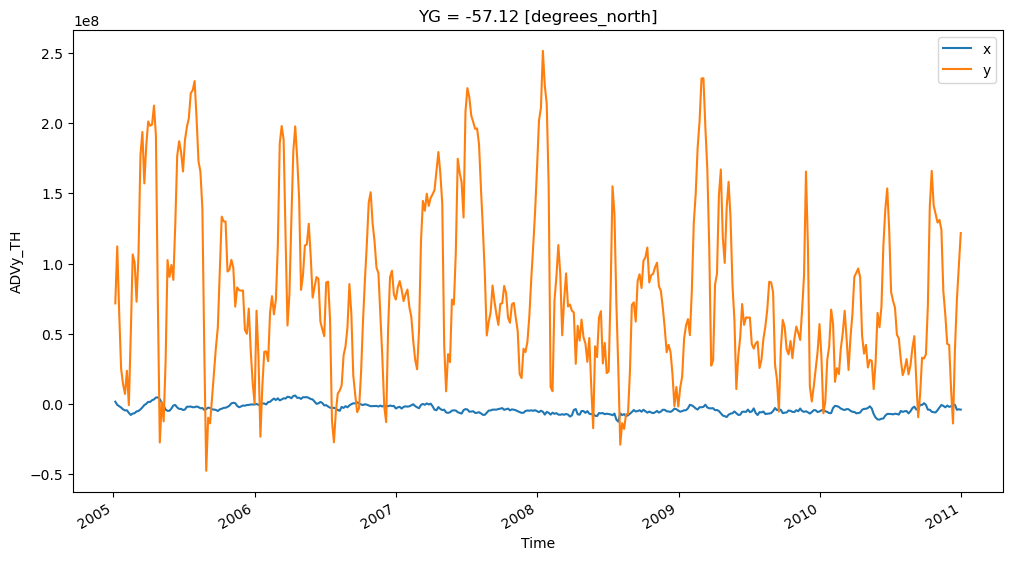

In [184]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

In [21]:
#diffusive flux
diff_flux_y = ds.DFyE_TH.isel(YG=-1).sum(dim=['XC', 'Z']).load()
diff_flux_x = ds.DFxE_TH.isel(XG=-1).sum(dim=['YC', 'Z']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray ()>
array(36446.64, dtype=float32)
Coordinates:
    XG       float32 30.0
    time     datetime64[ns] 2005-06-05
    YG       float32 -57.12

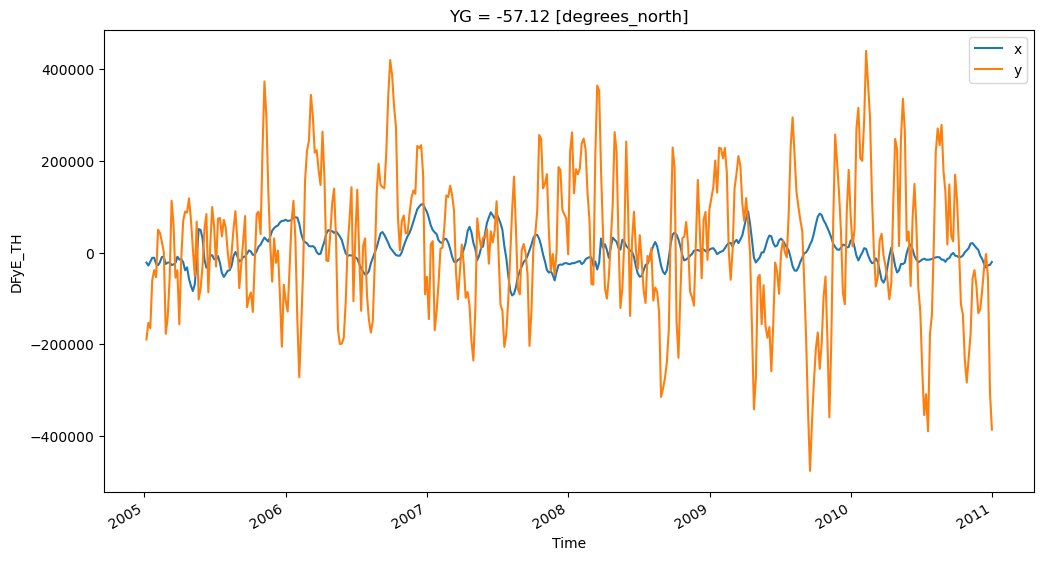

In [186]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend();

In [59]:
#vertical flux
t_flux_z = (ds.TFLUX * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray ()>
array(-5.777272e+14, dtype=float32)
Coordinates:
    Z        float32 -5.0
    time     datetime64[ns] 2005-06-05

In [60]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(ds.WTHMASS.isel(Zl=0, drop=True) * coords.rA).sum(dim=['XC', 'YC'])
#i noticed lin_fs_corr term didn't have `**lon_range` - should it not have?
#units: (˚C m^3)/s

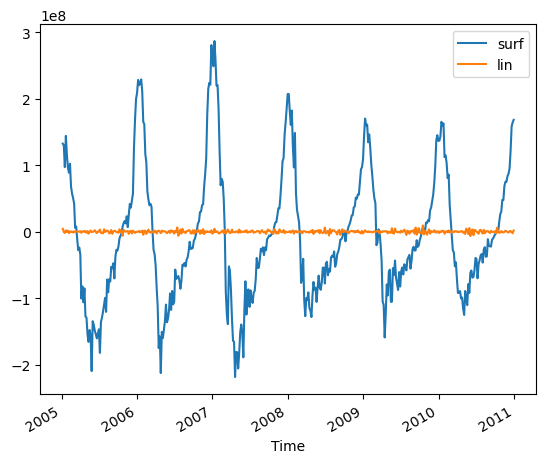

In [142]:
surface_term.plot(label='surf')
lin_fs_correction.plot(label='lin')
plt.legend()

In [64]:
tottend_weddell = (ds.TOTTTEND * coords.rA * coords.drF * coords.hFacC).sum(dim=['XC', 'YC']) / (24*60*60)
tottend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray ()>
array(-9798345.00740741)
Coordinates:
    Z        float32 -5.0
    time     datetime64[ns] 2005-06-05

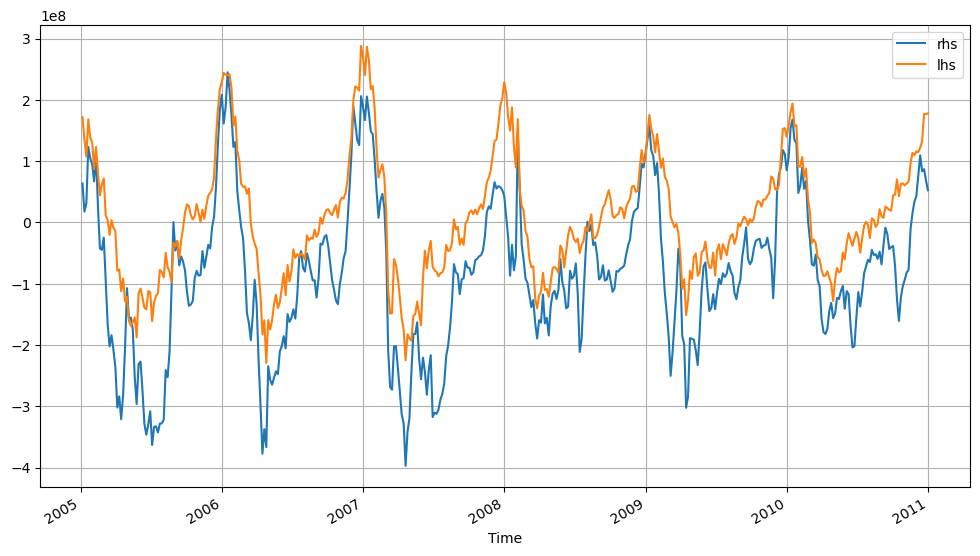

In [192]:
rhs = - adv_flux.drop(('XG', 'YG')) - diff_flux.drop(('XG', 'YG')) + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

In [65]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

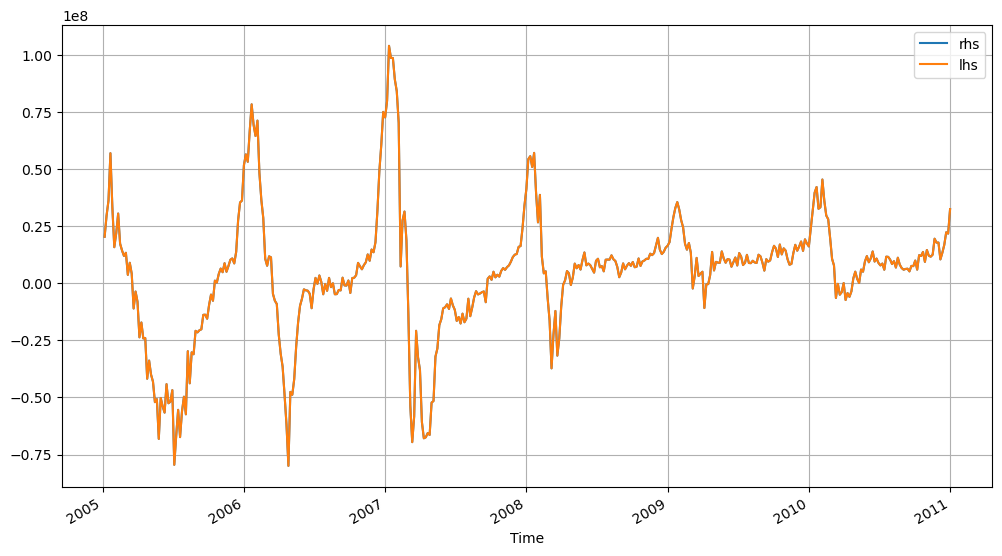

In [94]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

In [ ]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      -adv_flux.rename('adv_flux'),
                      -diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

In [ ]:
plt.figure(figsize=(12,6))
all_terms.to_array().plot.line(x='time')

In [ ]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

In [ ]:
df.plot(figsize=(12,6), kind='bar')
plt.grid();

In [ ]:
adv_flux_clim = (adv_flux.groupby('time.month') 
                    - adv_flux.groupby('time.month').mean(dim='time'))
diff_flux_clim = (diff_flux.groupby('time.month') 
                      - diff_flux.groupby('time.month').mean(dim='time'))
surf_term_clim = (surface_term.groupby('time.month')
                  - surface_term.groupby('time.month').mean(dim='time'))
lin_fs_correction_clim = (lin_fs_correction.groupby('time.month') -
                          lin_fs_correction.groupby('time.month').mean(dim='time'))
tottend_weddell_clim = (tottend_weddell.groupby('time.month') 
                            - tottend_weddell.groupby('time.month').mean(dim='time'))

In [ ]:
all_terms_clim = xr.merge([-adv_flux_clim.rename('adv_flux'), 
                            -diff_flux_clim.rename('diff_flux'),
                            surf_term_clim.rename('surf_term'),
                            lin_fs_correction_clim.rename('lin_fs_corr'),
                            tottend_weddell_clim.rename('tottend')])
all_terms_clim

In [ ]:
plt.figure(figsize=(12,6))
all_terms_clim.to_array().plot.line(x='time')
plt.grid()
plt.title('Interannual Variability\nWG entire column');

In [ ]:
cov_adv = (np.cov(tottend_weddell_clim, -adv_flux_clim) / 
           np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_diff = (np.cov(tottend_weddell_clim, -diff_flux_clim) / 
            np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_surf = (np.cov(tottend_weddell_clim, surf_term_clim) / 
            np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_lin_fs = (np.cov(tottend_weddell_clim, lin_fs_correction_clim) / 
            np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_tottend = (np.cov(tottend_weddell_clim, tottend_weddell_clim) /
               np.cov(tottend_weddell_clim, tottend_weddell_clim))

In [ ]:
cov_array = np.array([cov_adv[1,0], cov_diff[1,0], cov_surf[1,0], cov_lin_fs[1,0], cov_tottend[1,0]])
cov_array

In [ ]:
cov_array_terms = np.array(['adv', 'diff', 'surf', 'lin_fs_corr', 'tottend'])

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cov_array_terms, cov_array)
plt.grid()
plt.title('Covariance');

## Heat budget for Lower WG (-2,046m to bottom)

In [ ]:
left_lon = 299
upper_lat = -66
right_lon = 360
lower_lat = -78

In [ ]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Lower Surface Mask @ ~2046m\nLon[299,360]\nLat[-78,-66]');

In [ ]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [ ]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [ ]:
#advective flux
adv_flux_y_lower = dsr.ADVy_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['XC','Z']).load()
adv_flux_x_lower = dsr.ADVx_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['YC','Z']).load()
adv_flux_z_lower = dsr.ADVr_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [ ]:
#diffusive flux
diff_flux_y_lower = dsr.DFyE_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                dim=['XC','Z']).load()
diff_flux_x_lower = dsr.DFxE_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                dim=['YC','Z']).load()
diff_flux_z_lower =  ((dsr.DFrE_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.DFrI_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.KPPg_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                                                                                                 ).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [ ]:
tottend_weddell_lower = ((dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                    dim=['XC', 'YC','Z'])) / (24*60*60)
tottend_weddell_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
rhs_lower = - adv_flux_lower - diff_flux_lower
lhs_lower = tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();

In [ ]:
all_terms_lower = xr.merge([-adv_flux_lower.rename('adv_flux'), 
                            -diff_flux_lower.rename('diff_flux'),
                            tottend_weddell_lower.rename('tottend')])
all_terms_lower

In [ ]:
plt.figure(figsize=(12,6))
all_terms_lower.to_array().plot.line(x='time')
plt.grid();

In [ ]:
df_lower = all_terms_lower.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df_lower

In [ ]:
df_lower.plot(figsize=(12,6), kind='bar')
plt.grid()

In [ ]:
(rhs_lower - lhs_lower).plot(figsize=(12,6))
plt.grid();

In [ ]:
adv_flux_lower_clim = (adv_flux_lower.groupby('time.month') 
                    - adv_flux_lower.groupby('time.month').mean(dim='time'))
diff_flux_lower_clim = (diff_flux_lower.groupby('time.month') 
                      - diff_flux_lower.groupby('time.month').mean(dim='time'))
tottend_weddell_lower_clim = (tottend_weddell_lower.groupby('time.month') 
                            - tottend_weddell_lower.groupby('time.month').mean(dim='time'))

In [ ]:
all_terms_lower_clim = xr.merge([-adv_flux_lower_clim.rename('adv_flux'), 
                            -diff_flux_lower_clim.rename('diff_flux'),
                            tottend_weddell_lower_clim.rename('tottend')])
all_terms_lower_clim

In [ ]:
plt.figure(figsize=(12,6))
all_terms_lower_clim.to_array().plot.line(x='time')
plt.grid()
plt.title('Interannual Variability\nWG lower column');

In [ ]:
cov_adv_lower = (np.cov(tottend_weddell_lower_clim, -adv_flux_lower_clim) / 
           np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim))
cov_diff_lower = (np.cov(tottend_weddell_clim, -diff_flux_lower_clim) / 
            np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim))
cov_tottend_lower = (np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim) /
               np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim))

In [ ]:
cov_adv_lower

In [ ]:
cov_diff_lower

In [ ]:
cov_tottend_lower

In [ ]:
cov_array_lower = np.array([cov_adv_lower[1,0], cov_diff_lower[1,0], cov_tottend_lower[1,0]])
cov_array_lower

In [ ]:
cov_array_terms_lower = np.array(['adv_lower', 'diff_lower', 'tottend_lower'])

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cov_array_terms_lower, cov_array_lower)
plt.grid()
plt.title('Covariance');